In [1]:
from PIL import Image
from skimage import measure                       
from shapely.geometry import Polygon, MultiPolygon 
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from Utils.training import iou_np
from Utils.build_dataset import paths_dataset
from Utils.coco_dataset import get_annotations, create_sub_mask_annotation
from torchvision import transforms
from Utils.training import training_loop, predict, iou_np
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.config import get_cfg
from detectron2 import model_zoo
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import cv2
import os

## Construindo o Dataset

In [2]:
path = 'Dataset/Fish_Dataset/Fish_Dataset/'
df_train_pd, df_valid_pd, df_test_pd = paths_dataset(path)

In [3]:
DatasetCatalog.register('fish_train', lambda: get_annotations(df_train_pd))
MetadataCatalog.get('fish_train').set(thing_classes=['fish'])
#fish_metadata = MetadataCatalog.get("fish_train")

namespace(name='fish_train', thing_classes=['fish'])

In [4]:
DatasetCatalog.register('fish_valid', lambda: get_annotations(df_valid_pd))
MetadataCatalog.get('fish_valid').set(thing_classes=['fish'])

namespace(name='fish_valid', thing_classes=['fish'])

In [5]:
DatasetCatalog.register('fish_test', lambda: get_annotations(df_test_pd))
MetadataCatalog.get('fish_test').set(thing_classes=['fish'])

namespace(name='fish_test', thing_classes=['fish'])

## Modelo Pre Treinado

In [6]:
df_test = get_annotations(df_test_pd)

In [7]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

D:\Softwares\anaconda3\envs\tf\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


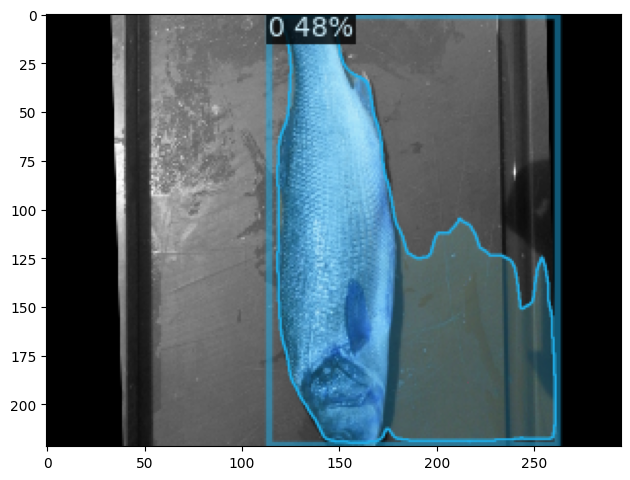

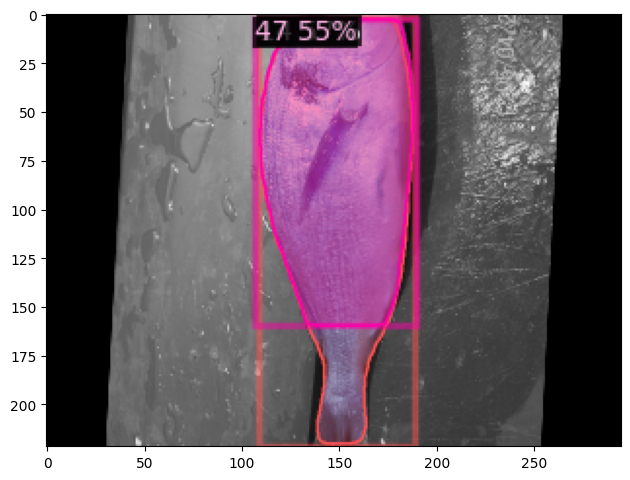

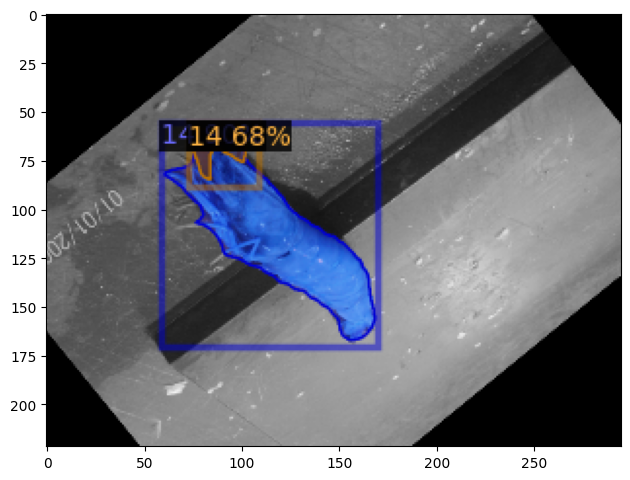

In [8]:
from detectron2.utils.visualizer import ColorMode
for d in random.sample(df_test, 3):
    fig = plt.figure(figsize=(10, 100))
    fig.add_subplot(15, 1, 1)
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   #metadata=fish_metadata, 
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])

In [9]:
iou_sum = 0
iou_list = []
for annon in df_test:
    im = cv2.imread(annon['file_name'])
    outputs = predictor(im)
    try:
        pred = outputs['instances'].pred_masks[0]
        pred = pred.to('cpu')
        pred_int = pred.long()
        pred_np = pred_int.numpy()
        iou_pred = iou_np(annon['mask'], pred_np)
    except:
        iou_pred = 0
    iou_sum += iou_pred
    iou_list.append(iou_pred)

iou = (iou_sum / len(df_test)) * 100
print(f'IoU: {iou:.1f}')

IoU: 62.2
